In [1]:
#pip install open3d

In [2]:
#pip install -U matplotlib

In [3]:
#pip install --upgrade setuptools

In [4]:
#pip install imageio

In [5]:
#pip install -U pandas

In [1]:
#pip install pyequilib

In [3]:
import imageio as iio
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from equilib import Equi2Pers

Part 1 point cloud

In [7]:
with open('../Project-demo/sample_data/test.npy', 'rb') as f:
    pcd = np.load(f)
print(pcd)

[[-2.14920429 -1.63684617  4.        ]
 [-1.6067541  -1.22763463  3.        ]
 [-3.20320998 -2.45526925  6.        ]
 ...
 [ 1.152787    2.20433945  8.        ]
 [ 0.58325899  1.10216972  4.        ]
 [ 0.59012447  1.10216972  4.        ]]


In [8]:
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

Part 2 point cloud

In [9]:
def compute_colored_pointcloud_nested_loops(depth_image, rgb_image):
    """
    Compute the colored point cloud using nested loops.
    This function is written for demonstration purposes.
    It takes time.
    :param depth_image: a depth image
    :param rgb_image: the corresponding rgb image
    :return: the colored point cloud
    """

    height, width = depth_image.shape
    colors = []
    pcd = []
    for i in range(height):
        for j in range(width):
            """
                Convert the pixel from depth coordinate system
                to depth sensor 3D coordinate system
            """
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH

            """
                Convert the point from depth sensor 3D coordinate system
                to rgb camera coordinate system:            
            """
            [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

            """
                Convert from rgb camera coordinate system
                to rgb image coordinate system:            
            """
            j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
            i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

            # Add point to point cloud:
            pcd.append([x, y, z])

            # Add the color of the pixel if it exists:
            if 0 <= j_rgb < width and 0 <= i_rgb < height:
                colors.append(rgb_image[i_rgb][j_rgb])
            else:
                colors.append([0., 0., 0.])
    return [np.array(pcd), np.array(colors)]

<ipython-input-10-b13152aad898>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  depth_image = iio.imread('../Project-demo/sample_data/depth_predict_1.png')
<ipython-input-10-b13152aad898>:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb_image = iio.imread('../Project-demo/sample_data/test_img_1.jpg')


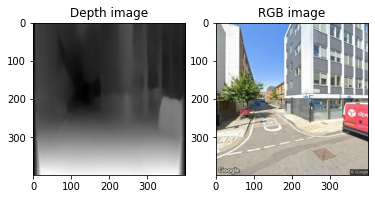

In [10]:
# here cx_depth should be about 200?? 
if __name__ == '__main__':
    # Depth Camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02

    # RGB camera intrinsic Parameters:
    FX_RGB = 5.1885790117450188e+02
    FY_RGB = 5.1946961112127485e+02
    CX_RGB = 3.2558244941119034e+0
    CY_RGB = 2.5373616633400465e+02

    # Rotation matrix:
    R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
    # Translation vector:
    T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

    # Read depth and color image:
    depth_image = iio.imread('../Project-demo/sample_data/depth_predict_1.png')
    rgb_image = iio.imread('../Project-demo/sample_data/test_img_1.jpg')
    #rgb_image = iio.imread('../Project-demo/sample_data/test_img.jpg')
    
    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    axs[0].set_title('Depth image')
    axs[1].imshow(rgb_image)
    axs[1].set_title('RGB image')
    plt.show()

    # compute point cloud:
    # Both images has the same resolution
    height, width = depth_image.shape

    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)

    # Compute constants:
    xx = (jj - CX_DEPTH) / FX_DEPTH
    yy = (ii - CY_DEPTH) / FY_DEPTH

    # transform depth image to vector of z:
    length = height * width
    z = depth_image.reshape(length)

    # compute point cloud
    pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))
    
    cam_RGB = np.apply_along_axis(np.linalg.inv(R).dot, 1, pcd) - np.linalg.inv(R).dot(T)
    xx_rgb = ((cam_RGB[:, 0] * FX_RGB) / cam_RGB[:, 2] + CX_RGB + width / 2).astype(int).clip(0, width - 1)
    yy_rgb = ((cam_RGB[:, 1] * FY_RGB) / cam_RGB[:, 2] + CY_RGB).astype(int).clip(0, height - 1)
    colors = rgb_image[yy_rgb, xx_rgb]



In [11]:
colors

Array([[169, 173, 172],
       [169, 173, 172],
       [169, 173, 172],
       ...,
       [193, 193, 185],
       [167, 167, 159],
       [193, 193, 185]], dtype=uint8)

In [12]:
with open('../Project-demo/sample_data/test_2_pcd.npy', 'wb') as f:
    np.save(f, pcd)

with open('../Project-demo/sample_data/test_2_colors.npy', 'wb') as f:
    np.save(f, colors)

Part 1 point cloud with color

In [13]:
with open('../Project-demo/sample_data/test_2_pcd.npy', 'rb') as f:
    pcd = np.load(f)
print(pcd)

[[-2.14920429 -1.63684617  4.        ]
 [-1.6067541  -1.22763463  3.        ]
 [-3.20320998 -2.45526925  6.        ]
 ...
 [ 1.152787    2.20433945  8.        ]
 [ 0.58325899  1.10216972  4.        ]
 [ 0.59012447  1.10216972  4.        ]]


In [14]:
with open('../Project-demo/sample_data/test_2_colors.npy', 'rb') as f:
    colors = np.load(f)
print(colors)

[[169 173 172]
 [169 173 172]
 [169 173 172]
 ...
 [193 193 185]
 [167 167 159]
 [193 193 185]]


In [15]:
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(np.array(colors / 255))
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

part 2 using default open 3d

In [15]:
# for 400*400 picture

In [16]:
depth_raw = o3d.io.read_image('../Project-demo/sample_data/depth_predict_1.png')
color_raw = o3d.io.read_image('../Project-demo/sample_data/test_img_1.jpg')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 400x400, with 1 channels.
Depth image : 400x400, with 1 channels.
Use numpy.asarray to access buffer data.


In [17]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [18]:
point_cloud_file_name = '../Project-demo/sample_data/point_cloud_test.ply'
o3d.io.write_point_cloud(point_cloud_file_name, pcd, write_ascii=False, compressed=False, print_progress=False)

True

In [19]:
# for 375*1242 picture

In [20]:
depth_raw = o3d.io.read_image('../Project-demo/sample_data/depth_predict.png')
color_raw = o3d.io.read_image('../Project-demo/sample_data/test_img.png')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 1242x375, with 1 channels.
Depth image : 1242x375, with 1 channels.
Use numpy.asarray to access buffer data.


In [21]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [22]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)
print(intrinsics)

PinholeCameraIntrinsic with width = 640 and height = 480.
Access intrinsics with intrinsic_matrix.


part 4

In [23]:
import requests

app_access_token = 'MLY|8443722902364390|832fa01211e391f5fd88c8a6186d2ff8' # create your access token at https://mapillary.com/developer
image_id = '169979785061521'
url = 'https://graph.mapillary.com/{}/?fields=id,camera_parameters,atomic_scale,thumb_original_url&access_token={}'.format(image_id,app_access_token)
# or instead of adding it to the url, add the token in headers (strongly recommended for user tokens)
headers = { "Authorization" : "OAuth {}".format(app_access_token) }
response = requests.get(url, headers)
data = response.json()

print(data)

{'id': '169979785061521', 'camera_parameters': [0.58551074610826, 0.0044488907520614, -0.032349286690073], 'atomic_scale': 1.2171837490563, 'thumb_original_url': 'https://scontent-xsp1-1.xx.fbcdn.net/m1/v/t6/An-lrUC2b2RsLVg4POu8hjHAUCiLVNI9aV08B7WKFuP3HaFvZB6yVxY3hIDsVyIPK5AxN2-T0I65K2ND_ILHn4eVnmrW4oXhQcm3UCOaPEWRnlI5HiUkHsOSWkVqMHC8bb-MaRhsENxYMnxlO2ozLA?ccb=10-5&oh=00_AfBhW2BpnroUzDULUpp51-9txlP5FpcEHa18Czbzv207_A&oe=6403B28F&_nc_sid=122ab1'}


In [24]:
depth_raw = o3d.io.read_image('../Project-demo/sample_data/depth_predict_2.png')
color_raw = o3d.io.read_image('../Project-demo/sample_data/test_img_2.jpg')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 3840x2160, with 1 channels.
Depth image : 3840x2160, with 1 channels.
Use numpy.asarray to access buffer data.


In [25]:
2160/2

1080.0

In [24]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [25]:
o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault).intrinsic_matrix

array([[525. ,   0. , 319.5],
       [  0. , 525. , 239.5],
       [  0. ,   0. ,   1. ]])

In [26]:
phc = o3d.camera.PinholeCameraIntrinsic()
phc.set_intrinsics(3840, 2160, 0.58551074610826*3840, 0.58551074610826*2140, 1920, 1080)
phc.intrinsic_matrix


array([[2.24836127e+03, 0.00000000e+00, 1.92000000e+03],
       [0.00000000e+00, 1.25299300e+03, 1.08000000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [27]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, phc)
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [28]:
phc = o3d.camera.PinholeCameraIntrinsic()
phc.set_intrinsics(3840, 2160, 0.58551074610826*3840, 0.58551074610826*2140, 1920, 1080)
phc.intrinsic_matrix


array([[2.24836127e+03, 0.00000000e+00, 1.92000000e+03],
       [0.00000000e+00, 1.25299300e+03, 1.08000000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [29]:
import PIL.Image as pil
path = '../Project-demo/sample_data/depth_predict_1.png'

depth_raw  = pil.open(path).convert('RGB')

width,height = depth_raw.size
f = 0.7
fx = f * width
fy = f * height
cx = width/2
cy = height/2

In [30]:
## autonomize the process
depth_raw = o3d.io.read_image('../Project-demo/sample_data/depth_predict_1.png')
color_raw = o3d.io.read_image('../Project-demo/sample_data/test_img_1.jpg')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 400x400, with 1 channels.
Depth image : 400x400, with 1 channels.
Use numpy.asarray to access buffer data.


In [31]:
phc = o3d.camera.PinholeCameraIntrinsic()

phc.set_intrinsics(width, height, fx, fy, cx, cy)
phc.intrinsic_matrix

array([[280.,   0., 200.],
       [  0., 280., 200.],
       [  0.,   0.,   1.]])

In [32]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [ ]:
import PIL.Image as pil
path = '../Project-demo/sample_data/depth_predict_3.png'

depth_raw  = pil.open(path).convert('RGB')

width,height = depth_raw.size
f = 0.7
fx = f * width
fy = f * height
cx = width/2
cy = height/2

In [33]:
## autonomize the process
depth_raw = o3d.io.read_image('../Project-demo/sample_data/depth_predict_3.png')
color_raw = o3d.io.read_image('../Project-demo/sample_data/test_img_3.jpg')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 2048x1024, with 1 channels.
Depth image : 2048x1024, with 1 channels.
Use numpy.asarray to access buffer data.


In [34]:
phc = o3d.camera.PinholeCameraIntrinsic()

phc.set_intrinsics(width, height, fx, fy, cx, cy)
phc.intrinsic_matrix

array([[280.,   0., 200.],
       [  0., 280., 200.],
       [  0.,   0.,   1.]])

In [35]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [47]:
print(np.asarray(pcd.points))

[[-1.19327734e-05  8.94491149e-06 -1.96078436e-05]
 [-9.51634030e-06  7.15592936e-06 -1.56862752e-05]
 [-7.11484599e-06  5.36694681e-06 -1.17647060e-05]
 ...
 [ 1.16000005e-03 -5.26722712e-04 -3.52941192e-04]
 [ 1.16067232e-03 -5.26722712e-04 -3.52941192e-04]
 [ 1.16134459e-03 -5.26722712e-04 -3.52941192e-04]]


#### C++ 

List<double> pnt;                   // 3D point list x0,y0,z0,x1,y1,z1,...
void compute()
    {
    int x,y,xs,ys;      // texture positiona and size
    double a,b,r,da,db; // spherical positiona and angle steps
    double xx,yy,zz;    // 3D point
    DWORD *p;           // texture pixel access
    // load and prepare BMP texture
    Graphics::TBitmap *bmp=new Graphics::TBitmap;
    
    
    bmp->LoadFromFile("map.bmp");
    bmp->HandleType=bmDIB;
    bmp->PixelFormat=pf32bit;
    xs=bmp->Width;
    ys=bmp->Height;
/*
    // 360x180 deg
    da=2.0*M_PI/double(xs-1);
    db=1.0*M_PI/double(ys-1);
    b=-0.5*M_PI;
*/
    // 180x90 deg
    da=1.0*M_PI/double(xs-1);
    db=0.5*M_PI/double(ys-1);
    b=-0.25*M_PI;

    // proces all its pixels
    pnt.num=0;
    for (                                 y=0; y<ys; y++,b+=db)
     for (p=(DWORD*)bmp->ScanLine[y],a=0.0,x=0; x<xs; x++,a+=da)
        {
        // pixel access
        r=DWORD(p[x]&255);  // obtain intensity from texture <0..255>
        r/=255.0;           // normalize to <0..1>
        // convert to 3D
        xx=r*cos(a)*cos(b);
        yy=r*sin(a)*cos(b);
        zz=r*       sin(b);
        // store to pointcloud
        pnt.add(xx);
        pnt.add(yy);
        pnt.add(zz);
        }
    // clean up
    delete bmp;
    }

In [98]:
pnt = []  # 3D point list x0, y0, z0, x1, y1, z1, ...
from PIL import Image

def compute():
    x, y, xs, ys = 0, 0, 0, 0  # texture position and size
    a, b, r, da, db = 0.0, 0.0, 0.0, 0.0, 0.0  # spherical position and angle steps
    xx, yy, zz = 0.0, 0.0, 0.0  # 3D point

    # Load and prepare BMP texture
    bmp = Image.open('../Project-demo/sample_data/depth_predict_3.png')

    xs, ys = bmp.size

    # 180x90 deg
    da = 1.0 * 3.14 / (xs - 1)
    db = 0.5 * 3.14 / (ys - 1)
    b = -0.5 * 3.14

    # Process all its pixels
    pnt.clear()
    for y in range(ys):
        b += db
        for x in range(xs):
            a += da

            # Pixel access
            r = bmp.getpixel((x, y))[0]  # obtain intensity from texture <0..255>
            r /= 255.0  # normalize to <0..1>

            # Convert to 3D
            xx = r * cos(a) * cos(b)
            yy = r * sin(a) * cos(b)
            zz = r * sin(b)

            # store to pointcloud
            pnt.append(xx)
            pnt.append(yy)
            pnt.append(zz)

    # Clean up
    bmp.close()

In [99]:
pnt = []  # 3D point list x0, y0, z0, x1, y1, z1, ...
clr = []
from PIL import Image

x, y, xs, ys = 0, 0, 0, 0  # texture position and size
a, b, r, da, db = 0.0, 0.0, 0.0, 0.0, 0.0  # spherical position and angle steps
xx, yy, zz = 0.0, 0.0, 0.0  # 3D point
    
depth_img = Image.open('../Project-demo/sample_data/depth_predict_3.png')
color_img = Image.open('../Project-demo/sample_data/test_img_3.jpg')

xs, ys = depth_img.size

# 180x90 deg
da = 1.0 * 3.14 / (xs - 1)
db = 0.5 * 3.14 / (ys - 1)
b = -0.25 * 3.14

# Process all its pixels
pnt.clear()
for y in range(ys):
    b += db
    for x in range(xs):
        a += da

        # Pixel access
        r = depth_img.getpixel((x, y))  # obtain intensity from texture <0..255>
        r /= 255.0  # normalize to <0..1>

        # Convert to 3D
        xx = r * np.cos(a) * np.cos(b)
        yy = r * np.sin(a) * np.cos(b)
        zz = r * np.sin(b)

        # store to pointcloud
        pnt.append([xx,yy,zz])
        
        c = color_img.getpixel((x, y))
        c0 = c[0]/255.0
        c1 = c[1]/255.0
        c2 = c[2]/255.0
        
    
        clr.append([c0,c1,c2])
        



In [100]:
clr

[[0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9450980392156862, 0.9921568627450981, 0.9921568627450981],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.9882352941176471],
 [0.9411764705882353, 0.9882352941176471, 0.98823529411

In [101]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pnt)
pcd.colors = o3d.utility.Vector3dVector(np.array(clr))

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [88]:
import numpy as np
import cv2

# Load the panoramic image
panorama = cv2.imread('../Project-demo/sample_data/depth_predict_3.png')

# Establish the camera parameters
focal_length = panorama.shape[1]
center = (panorama.shape[1]/2, panorama.shape[0]/2)
camera_matrix = np.array([[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]])

# Extract the depth map from the panoramic image
depth_map = np.zeros((panorama.shape[0], panorama.shape[1])) # Assuming a flat depth map for demonstration purposes

# Convert the pixel coordinates to spherical coordinates
spherical_coords = np.zeros((panorama.shape[0], panorama.shape[1], 3))
for row in range(panorama.shape[0]):
    for col in range(panorama.shape[1]):
        x, y = np.array([col, row]).reshape(2, 1)
        
        spherical_coords[row, col, :2] = np.array([np.arctan2(x - center[0], focal_length), np.arctan2(y - center[1], focal_length)])
        
        spherical_coords[row, col, 2] = depth_map[row, col]

# Convert the spherical coordinates to Cartesian coordinates
x = spherical_coords[..., 2] * np.sin(spherical_coords[..., 1]) * np.cos(spherical_coords[..., 0])
y = spherical_coords[..., 2] * np.sin(spherical_coords[..., 1]) * np.sin(spherical_coords[..., 0])
z = spherical_coords[..., 2] * np.cos(spherical_coords[..., 1])

# Stack the Cartesian coordinates to form a point cloud
point_cloud = np.stack((x, y, z), axis=-1)


ValueError: could not broadcast input array from shape (2,1) into shape (2)

In [89]:
import numpy as np
import cv2
from math import sin, cos, pi

def convert_to_3d(img):
    # Load the image
    pano_img = cv2.imread(img)
    
    # Convert to grayscale
    gray = cv2.cvtColor(pano_img, cv2.COLOR_BGR2GRAY)
    
    # Get image dimensions
    h, w = gray.shape
    
    # Normalize intensity values to a range of 0 to 1
    gray = gray / 255.0
    
    # Initialize list to store 3D points
    points = []
    
    # Map the 2D image to a 3D spherical coordinate system
    for y in range(h):
        for x in range(w):
            theta = pi * (x / w - 0.5)
            phi = pi * (y / h - 0.5)
            
            r = gray[y, x]
            
            x = r * cos(theta) * cos(phi)
            y = r * sin(theta) * cos(phi)
            z = r * sin(phi)
            
            points.append([x, y, z])
    
    return np.array(points)

pano_img = '../Project-demo/sample_data/depth_predict_3.png'
points = convert_to_3d(pano_img)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [97]:
import numpy as np
import cv2
from math import sin, cos, pi


# Load the image
pano_img = cv2.imread('../Project-demo/sample_data/depth_predict_3.png')
color_img = cv2.imread('../Project-demo/sample_data/test_img_3.jpg')

    
# Convert to grayscale
gray = cv2.cvtColor(pano_img, cv2.COLOR_BGR2GRAY)
    
# Get image dimensions
h, w = gray.shape
    
# Normalize intensity values to a range of 0 to 1
#gray = gray / 255.0
    
# Initialize list to store 3D points
points = []
    
# Map the 2D image to a 3D spherical coordinate system
for y in range(h):
    for x in range(w):
        theta = pi * (x / w - 0.5)
        phi = pi * (y / h - 0.5)
 
        r = depth_img.getpixel((x, y))  # obtain intensity from texture <0..255>
            
        x = r * cos(theta) * cos(phi)
        y = r * sin(theta) * cos(phi)
        z = r * sin(phi)
            
        points.append([x, y, z])
    


points

[[1.8746997283273223e-32, -3.061616997868383e-16, -5.0],
 [3.757167850178199e-19, -2.4492907165824916e-16, -4.0],
 [5.635745144533434e-19, -1.836961553589472e-16, -3.0],
 [5.635734093320063e-19, -1.2246338314627304e-16, -2.0],
 [1.1271437243286685e-18, -1.8369356182761688e-16, -3.0],
 [1.4089246823812667e-18, -1.8369161668712911e-16, -3.0],
 [2.2542697667973753e-18, -2.4491898573669785e-16, -4.0],
 [2.6299679859051584e-18, -2.449152395725252e-16, -4.0],
 [3.757075020555282e-18, -3.0613864637391997e-16, -5.0],
 [4.2266812179686746e-18, -3.0613252290837667e-16, -5.0],
 [5.635532963511536e-18, -3.6735081490012296e-16, -6.0],
 [7.232207738591672e-18, -4.2856536088128195e-16, -7.0],
 [7.889610001669807e-18, -4.285537625900619e-16, -7.0],
 [9.767992799695538e-18, -4.897613209947906e-16, -8.0],
 [1.1834173653294224e-17, -5.509639809669683e-16, -9.0],
 [1.2679327559977227e-17, -5.50945179343329e-16, -9.0],
 [1.5027168478864115e-17, -6.121389792138483e-16, -10.0],
 [1.7562775850445475e-17, -6.7

In [94]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

o3d.visualization.draw_geometries([pcd])

In [99]:
o3d.visualization.draw_geometries([pcd])

In [96]:
import cv2
import numpy as np

# Load the panorama image and its depth map
panorama_image = cv2.imread('../Project-demo/sample_data/test_img_3.jpg')
depth_map = cv2.imread('../Project-demo/sample_data/depth_predict_3.png', cv2.IMREAD_ANYDEPTH)

# Define the intrinsic parameters of the camera
focal_length = ... # Fill in the focal length of the camera
principal_point = (..., ...) # Fill in the principal point of the camera

# Convert the depth values to 3D points in the camera coordinate system
rows, cols = depth_map.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
Z = depth_map / 1000.0

# Define the intrinsic parameters of the camera
focal_length = 0.5 # Fill in the focal length of the camera
principal_point = (X/2, Y/2) # Fill in the principal point of the camera

points_3d = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
points_3d = np.column_stack(((points_3d - principal_point) * Z / focal_length, Z))

# Transform the 3D points into the world coordinate system
R = ... # Fill in the rotation matrix
t = ... # Fill in the translation vector
points_3d = (R @ points_3d.T + t).T

# Store the resulting 3D points in a point cloud data structure
point_cloud = np.column_stack((points_3d, panorama_image[Y, X]))

ValueError: operands could not be broadcast together with shapes (2097152,3) (2,1024,2048) 